Just initialize the connection to the Java virtual machine

In [1]:
import os
from py4j.java_gateway import JavaGateway

gateway = JavaGateway()   # connect to the JVM

scriptdir = os.getcwd() # Location of script, used to find configuration files

Some utility routines we should use them from the py_openda package but that does not work now. Hence a shortcut.

In [2]:
def initialize_openda_configurable(openda_configurable, input_dir, config_xml):
    """
    Initialise an OpenDA configurable (e.g. ModelFactory, StochObserver).

    :param openda_configurable: OpenDA object implementing IConfigurable.
    :param input_dir: Working directory/input directory.
    :param config_xml: Configuration file.
    :return:
    """

    # Translate the input strings to java objects (File and String array)
    j_input_dir = gateway.jvm.java.io.File(input_dir)
    string_class = gateway.jvm.String
    j_arguments = gateway.new_array(string_class, 1)
    j_arguments[0] = config_xml

    # Initialize ..
    openda_configurable.initialize(j_input_dir, j_arguments)
    
def py_list_to_j_array(py_x):
    """
    Create a java double array from python list

    :param py_x: python list of doubles
    :return: java array of doubles copy of py_x
    """
    n = len (py_x)
    double_class = gateway.jvm.double
    j_x = gateway.new_array(double_class, n)

    for i in range(n):
        j_x[i]=py_x[i]

    return j_x

def j_array_to_py_list(j_x):
    """
    Create a python list from a java array
    :param j_x: java array
    :return: python list with values of j_x
    """

    n = len(j_x)
    py_x =[None]*n
    for i in range(n):
        py_x[i]=j_x[i]

    return py_x

We initialize our lorenz model and observation database (stoch observer). The only thing we do here is set the configuration files of these building blocks and initialize them (note both are called "configurable" in OpenDA)

In [3]:
    #Initialize the model factory
    #model_input_dir = "/Users/nils/Develop/py4j/swanModel/config"
    model_input_dir = os.path.join(scriptdir, 'model')
    model_config_xml = "LorenzStochModel.xml"


    model_factory = gateway.jvm.org.openda.models.lorenz.LorenzStochModelFactory()
    initialize_openda_configurable(model_factory, model_input_dir, model_config_xml)

    #Initialize stoch observer
    observer_input_dir = os.path.join(scriptdir, 'observations')
    observer_config_xml = "observations_lorenz_generated.csv"

    observer = gateway.jvm.org.openda.observers.CsvStochObserver()
    initialize_openda_configurable(observer, observer_input_dir, observer_config_xml)


Just play a bit with an instance of the Lorenz model.
* Create an instance
* get simulation horizon
* Plot the initial state
* Add pertubation to state AXPY -> Y=A*X+Y (Y interal model state, X and A are given arguments)

In [4]:
outputLevel = gateway.jvm.org.openda.interfaces.IStochModelFactory.OutputLevel.Debug
x1=model_factory.getInstance(outputLevel);

In [5]:
print(x1.getTimeHorizon())

0.0:0.025:30.0


In [6]:
print(j_array_to_py_list(x1.getState().getValues()))

[1.50888, -1.531271, 25.46091]


In [10]:
dx=x1.getState();   #Just get a java treevector of size and shape of state vector
dx.setValues(py_list_to_j_array([-1.0, 1.0, 2.0])) #Set some values in dx
print(j_array_to_py_list(dx.getValues()))

[-1.0, 1.0, 2.0]


In [11]:
x1.axpyOnState(1.0, dx)  # state = state + 1.0*dx
print(j_array_to_py_list(x1.getState().getValues()))

[0.50888, 0.46872899999999995, 29.46091]


In [13]:
m3=model_factory.getInstance(outputLevel)
x1=[]
for t in range(100):
    tstop=gateway.jvm.org.openda.utils.Time(0.1*t)
    m3.compute(tstop)
    #print(m3.getCurrentTime())
    xval1=j_array_to_py_list(m3.getState().getValues())
    x1.append(xval1[0])
    

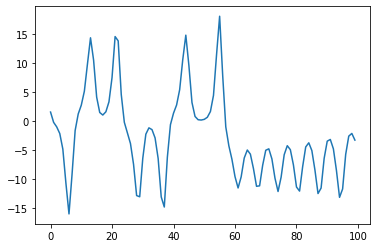

In [14]:
import matplotlib.pyplot as plt
plt.plot(x1)